# CIFAR-10 Image Classification

## Table of Contents
- [Introduction](#introduction)
- [Load the CIFAR-10 dataset](#load-the-dataset)
- [Investigate and preprocess the dataset](#investigate-and-preprocess-the-dataset)
- [Model performance evaluation functions](#model-performance-evaluation-functions)
- [Model hyperparameter tuning functions](#model-hyperparameter-tuning-functions)
- [Build a simple neural network](#simple-neural-network)
    - [Compare different activation functions](#compare-activation-functions)
    - [Compare different optimisers](#compare-optimisers)
    - [Compare different learning rates](#compare-learning-rates)
    - [Compare different convolutional kernel sizes and number of filters](#compare-kernel-sizes)
    - [Create tuned single-layer model](#tuned-single-layer-model)
- [Build a more complex neural network](#more-complex-model)
    - [Compare different activation functions](#complex-compare-activation-functions)
    - [Compare different optimisers](#complex-compare-optimisers)
    - [Compare different learning rates](#complex-compare-learning-rates)
    - [Compare different convolutional kernel sizes and number of filters](#complex-compare-kernel-sizes)
    - [Create tuned multi-layer model](#tuned-multi-layer-model)
- [Build a deep convolutional neural network with VGG architecture](#build-deep-cnn)
    - [Single VGG block](#single-vgg-block)
    - [Double VGG block](#double-vgg-block)
    - [Triple VGG block](#triple-vgg-block)
    - [Model Regularisation](#model-regularisation)
- [Conclusion](#conclusion)


## Introduction <a class="anchor" id="introduction"></a>

Throughout this notebook, the CIFAR-10 dataset will be used to experiment with different neural network architectures and their hyperparamters. The three architectures that will be explored are:
- A simple neural network
- A more complex neural network
- A deep convolutional neural network with VGG architecture

The first two architectures will be used to explore the effect of different hyperparameters on the performance of the models. The deep convolutional neural network architecture will be used to explore the effect of stacking multiple convolutional layers (VGG blocks) on the performance of the model, along with how different regularisation techniques can be used to improve the performance of the model.

First, we need to import the required libraries:
- Tensorflow (Keras) for building and training the models
- Sklearn for splitting the dataset into training, validation and test sets
- Matplotlib for plotting the results
- Numpy for manipulating the data

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

## Load the CIFAR-10 dataset <a class="anchor" id="load-the-dataset"></a>

Import the CIFAR-10 dataset from Keras using the load_data function and one-hot encode the labels. One hot encoding converts the labels into a binary matrix where each row corresponds to an image and each column corresponds to a class in the CIFAR-10 dataset.

In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Investigate and preprocess the dataset <a class="anchor" id="investigate-and-preprocess-the-dataset"></a>

Investigate the properties of the training and test data by printing the number of rows, the resolution of each image, the number of channels, and the number of different classes.

In [3]:
print(f"Number of training data rows: {x_train.shape[0]}")
print(f"Number of test data rows: {x_test.shape[0]}")
print(f'Resolution of each image: {x_train.shape[1]} x {x_train.shape[2]}')
print(f'Number of channels: {x_train.shape[3]}')
print(f'Number of classes: {len(np.unique(y_train))}')

Number of training data rows: 50000
Number of test data rows: 10000
Resolution of each image: 32 x 32
Number of channels: 3
Number of classes: 2


We can see that there are 50,000 training images and 10,000 test images meaning that the dataset is split into ~83% training and ~17% test data. Each image is 32x32 pixels with 3 channels (RGB).

In order to effectively compare the models, we need to create a validation set. In this case, we will take 20% of the training set as the validation set and use stratification to ensure that the classes are evenly distributed between the training and validation sets.

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

Display an image corresponding to each of the 10 classes using matplotlib

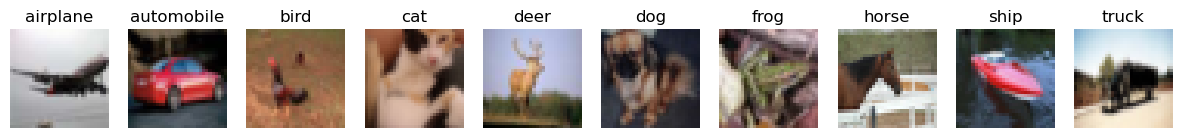

In [5]:
target_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

figure, axis = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(len(target_names)):
    index = np.argmax(y_train, axis=1) == i
    index = np.argmax(index)
    axis[i].imshow(x_train[index])
    axis[i].set_title(target_names[i])
    axis[i].axis('off')
plt.show()

As the images use the RGB colour model, the pixel values for each image are positive integers in the range of [0,255]. Therefore, we need to normalise the pixel values into the range of [0,1].

In [6]:
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

## Model performance evaluation functions <a class="anchor" id="model-performance-evaluation-functions"></a>

In order to effectively compare the performance of the different models that will be created throughout this notebook, we need to create some functions that will help to evaluate them.

Create a function to display the accuracy and loss of the model over the training and validation sets using matplotlib

In [7]:
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']


def plot_training_accuracy_loss(history: [tf.keras.callbacks.History], keys: [str] = None):
    # Check that the number of keys matches the number of histories to prevent KeyError
    if keys:
        assert (len(history) == len(keys))
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # Loop through each history and plot the accuracy and loss
    for i, h in enumerate(history):
        colour = colours[i % len(colours)]
        axs[0].plot(h.history['accuracy'], label=f'Training Accuracy {keys[i] if keys else ""}', color=colour)
        axs[0].plot(h.history['val_accuracy'], label=f'Validation Accuracy {keys[i] if keys else ""}', color=colour,
                    linestyle='--')
        axs[1].plot(h.history['loss'], label=f'Training Loss {keys[i] if keys else ""}', color=colour)
        axs[1].plot(h.history['val_loss'], label=f'Validation Loss {keys[i] if keys else ""}', color=colour,
                    linestyle='--')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='upper left')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='lower left')
    plt.show()

Create a function to display a tensorflow confusion matrix based on predictions made on the test set

In [8]:
def confusion_matrix(model: tf.keras.Model):
    # Predict the labels of the test set
    predictions = model.predict(x_test, verbose=0)
    # Convert the one-hot encoded predictions and labels into single integers
    predictions = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    # Create a confusion matrix
    cm = tf.math.confusion_matrix(true_labels, predictions)
    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks(np.arange(10))
    plt.yticks(np.arange(10))
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.show()

Create a function to calculate the accuracy and loss of the model on the test set and display the confusion matrix

In [9]:
def test_model(model: tf.keras.Model):
    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f'Test accuracy: {test_acc}')
    print(f'Test loss: {test_loss}')
    # Create a confusion matrix
    confusion_matrix(model)

## Model hyperparameter tuning functions <a class="anchor" id="model-hyperparameter-tuning-functions"></a>

To make this notebook easier to read and prevent repeated code, these functions were created for evaluating different configurations of the single-layer and multi-layer architectures. Functions have been created to test different:
* Activation functions
* Optimisers
* Learning rates
* Convolutional kernel sizes
* Numbers of convolutional filters

Each of these functions will produce an accuracy vs epoch graph and a loss vs epoch graph for each configuration tested. The function will also return the history of the training process for each configuration tested.

First, let's create a function to evaluate the performance of a model with different activation functions. Three of the most common activation functions will be tested:
* ReLU
* Sigmoid
* Tanh

The function takes a model as an argument, then replaces the activation function with each of the three activation functions to be tested in the convolutional and dense layers. The function then compiles and trains the models and returns the history of the training process of each model.

In [10]:
def evaluate_activation_functions(model: tf.keras.Model) -> [tf.keras.callbacks.History]:
    # Create a list of activation functions to test
    activation_functions = [tf.keras.activations.relu, tf.keras.activations.sigmoid, tf.keras.activations.tanh]
    history = []
    for activation_function in activation_functions:
        # Clone the model
        new_model = clone_model(model)
        # Replace the activation function in each model layer except the output layer
        for layer in new_model.layers[:-1]:
            # If the layer is a convolutional layer or a fully connected layer, replace the activation function
            if layer.__class__.__name__ == 'Conv2D' or layer.__class__.__name__ == 'Dense':
                layer.activation = activation_function
        # Compile the model
        new_model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
        # Train the model and append the history
        history.append(new_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0))

    # Plot the accuracy and loss of the models
    plot_training_accuracy_loss(history, keys=['ReLU', 'Sigmoid', 'Tanh'])

    return history

Create a function to evaluate the performance of a model with three different popular optimisers:
* Adam
* SGD
* RMSprop

The function takes a model as an argument, then uses the optimiser to compile and train the model. It then displays the accuracy and loss of the model over the training and validation sets using matplotlib and returns the history of the training process of each model.

In [11]:
def evaluate_optimisers(model: tf.keras.Model) -> [tf.keras.callbacks.History]:
    # Create a list of optimisers to test
    optimisers = [tf.keras.optimizers.Adam(), tf.keras.optimizers.SGD(), tf.keras.optimizers.RMSprop()]
    history = []
    for optimiser in optimisers:
        # Clone the model
        new_model = clone_model(model)
        # Compile the model with the optimiser
        new_model.compile(optimizer=optimiser,
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
        # Train the model and append the history
        history.append(new_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0))

    # Plot the accuracy and loss of the models
    plot_training_accuracy_loss(history, keys=['Adam', 'SGD', 'RMSprop'])

    return history

Create a function to evaluate the performance of a model with different learning rates using the grid search method. The function will test the following learning rates:
* 0.0001
* 0.001
* 0.01

The function takes a model as an argument, then uses the learning rate on the Adam optimiser to compile and train the model. It then displays the accuracy and loss of the model over the training and validation sets and returns the history of the training process of each model.

In [12]:
def evaluate_learning_rates(model: tf.keras.Model) -> [tf.keras.callbacks.History]:
    learning_rates = [0.0001, 0.001, 0.01]
    history = []
    for learning_rate in learning_rates:
        # Clone the model
        new_model = clone_model(model)
        # Compile the model
        new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
        # Train the model and append the history
        history.append(new_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0))

    # Plot the accuracy and loss of the models
    plot_training_accuracy_loss(history, keys=['lr=0.0001', 'lr=0.001', 'lr=0.01'])

    return history

Create a function to evaluate the performance of a model with different convolutional kernel sizes. Given the size of the input images (32x32), the following kernel sizes are suitable to test:
* 3x3
* 5x5
* 7x7

The function takes a model as an argument, then replaces the kernel size in each convolutional layer with each of the three kernel sizes to be tested. The function then returns the history of the training process of each model.

In [13]:
def evaluate_kernel_sizes(model: tf.keras.Model) -> [tf.keras.callbacks.History]:
    kernel_sizes = [3, 5, 7]
    history = []
    for kernel_size in kernel_sizes:
        # Clone the model
        new_model = clone_model(model)
        # Replace the kernel size in each convolutional layer
        for layer in new_model.layers[:-1]:
            # If the layer is a convolutional layer, replace the kernel size
            if layer.__class__.__name__ == 'Conv2D':
                layer.kernel_size = (kernel_size, kernel_size)
        # Compile the model
        new_model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
        # Train the model and append the history
        history.append(new_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0))

    # Plot the accuracy and loss of the models
    plot_training_accuracy_loss(history, keys=['3x3', '5x5', '7x7'])

    return history

Create a function to evaluate the performance of a model with different numbers of convolutional filters. It is a good idea to start relatively small and then increase the number, thus the following numbers of filters will be tested:
* 32
* 64
* 128
* An additional configuration of filters in the multi-layer model: 32 in the first layer, 64 in the second layer, 128 in the third layer

The function takes a model as an argument, then replaces the number of filters in each convolutional layer with each of the three numbers of filters to be tested. The function then returns the history of the training process of each model.

In [14]:
def evaluate_num_of_filters(model: tf.keras.Model, custom_model: tf.keras.Model = None, custom_filters: str = None) -> [
    tf.keras.callbacks.History]:
    num_of_filters = [32, 64, 128]
    history = []
    for filter_num in num_of_filters:
        # Clone the model
        new_model = clone_model(model)
        # Replace the number of filters in each convolutional layer
        for layer in new_model.layers[:-1]:
            # If the layer is a convolutional layer, replace the layer with a new layer with the new number of filters
            if layer.__class__.__name__ == 'Conv2D':
                new_model.layers[new_model.layers.index(layer)] = Conv2D(filters=filter_num,
                                                                         kernel_size=layer.kernel_size,
                                                                         activation=layer.activation,
                                                                         padding=layer.padding)(layer.input)
        # Compile the model
        new_model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
        # Train the model and append the history
        history.append(new_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0))

    # If a custom model is provided, train it and append the history
    if custom_model:
        custom_model.compile(optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])
        history.append(custom_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0))
        # Plot the accuracy and loss of the models
        plot_training_accuracy_loss(history, keys=['32', '64', '128', str(custom_filters)])
        return history

    # Plot the accuracy and loss of the models
    plot_training_accuracy_loss(history, keys=['32 Filters', '64 Filters', '128 Filters'])
    return history

## Build a simple neural network <a class="anchor" id="simple-neural-network"></a>

Create a simple neural network consisting of a single convolutional layer, a flatten layer, and a single fully connected layer as a baseline:

- The first layer is a convolutional layer with 32 filters, a kernel size of 3x3. The input shape is 32x32x3 (the 3 corresponds to the 3 channels in the RGB colour model).
- This 1D array is passed to a single fully connected layer with 10 neurons and a softmax activation function, where each neuron corresponds to a class.
- The output of the softmax activation function is a probability distribution over the 10 classes in the CIFAR-10 dataset.
- The categorical cross-entropy loss function (as the labels are one-hot encoded and this is a good choice according to [the documentation](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class))

Start by using:
- ReLU activation function (as it is a good default choice)
- Adam optimiser (as it is a good default choice)

In [16]:
single_layer_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    Flatten(),
    Dense(10, activation='softmax')
])
single_layer_model.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy']
                           )

Train the model for 100 epochs with a batch size of 64 on the training data and evaluate the model on the validation data by calling the `fit` method on the model. The `fit` method returns a `History` object which contains the training and validation loss and accuracy over the epochs.

In [21]:
single_layer_model_history = single_layer_model.fit(x_train, y_train, batch_size=64, epochs=100,
                                                    validation_data=(x_val, y_val))

Epoch 1/100
625/625 [==============================] - 2s 3ms/step - loss: 1.5487 - accuracy: 0.4570 - val_loss: 1.3447 - val_accuracy: 0.5275
Epoch 2/100
625/625 [==============================] - 1s 2ms/step - loss: 1.2299 - accuracy: 0.5717 - val_loss: 1.2787 - val_accuracy: 0.5537
Epoch 3/100
625/625 [==============================] - 1s 2ms/step - loss: 1.1064 - accuracy: 0.6169 - val_loss: 1.2253 - val_accuracy: 0.5810
Epoch 4/100
625/625 [==============================] - 1s 2ms/step - loss: 1.0133 - accuracy: 0.6510 - val_loss: 1.1616 - val_accuracy: 0.5960
Epoch 5/100
625/625 [==============================] - 1s 2ms/step - loss: 0.9438 - accuracy: 0.6753 - val_loss: 1.1677 - val_accuracy: 0.6009
Epoch 6/100
625/625 [==============================] - 1s 2ms/step - loss: 0.8749 - accuracy: 0.6980 - val_loss: 1.2032 - val_accuracy: 0.5955
Epoch 7/100
625/625 [==============================] - 1s 2ms/step - loss: 0.8177 - accuracy: 0.7182 - val_loss: 1.1554 - val_accuracy: 0.6024

Evaluate the model by plotting the accuracy and loss over the training and validation sets

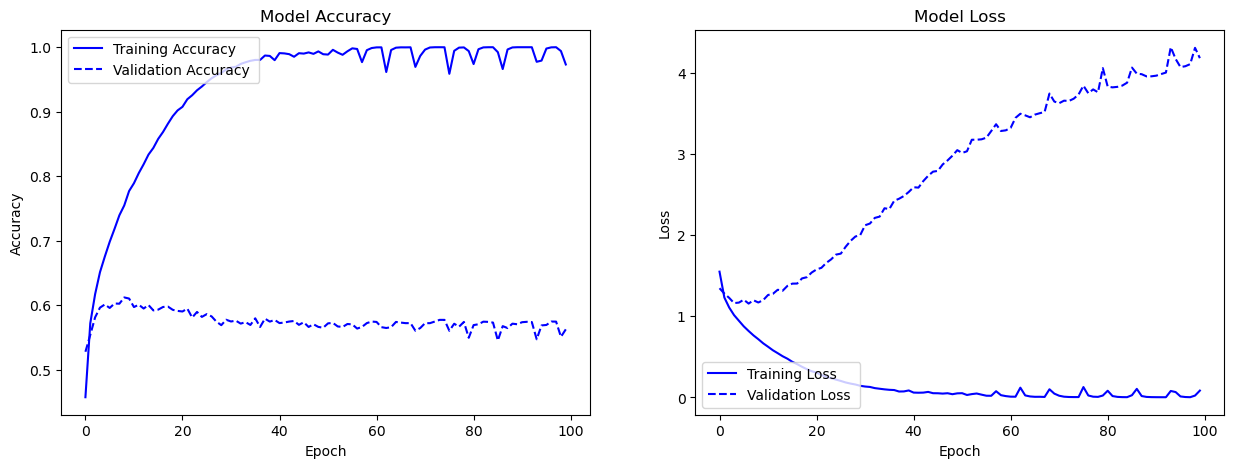

In [22]:
plot_training_accuracy_loss([single_layer_model_history])

It is clear that the model is overfitting the training data because the validation loss begins to increase after about 10 epochs and the training accuracy approaches 1.0. Later, regularisation techniques will be explored on a deep convolutional neural network to reduce overfitting. First, lets run the model on the test set and display the confusion matrix

Test accuracy: 0.5490000247955322
Test loss: 4.316599369049072


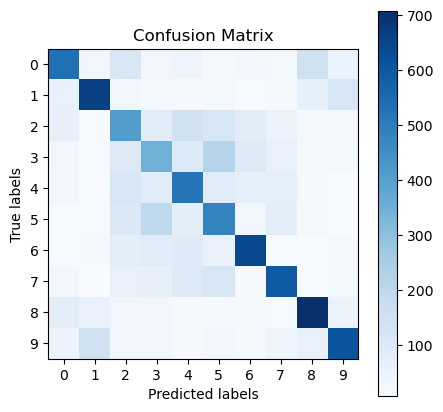

In [23]:
test_model(single_layer_model)

 The single-layer CNN showed reasonable performance with an accuracy of 56% on the testing set. The confusion matrix shows that it commonly mistook images with class 3 (cats) as class 5 (dogs) and vice versa which makes sense given they look fairly similar in 32x32 pixel images. Now we'll compare the performance of the model with different activation functions, and do an early stop after 20 epochs to reduce overfitting.

### Compare different activation functions <a class="anchor" id="compare-activation-functions"></a>

In order to compare the performance of the single-layer model with different activation functions, we can use the `evaluate_activation_functions` function defined earlier. This function takes a model as an argument and returns the history of the training process of each model that may be used later in the notebook.

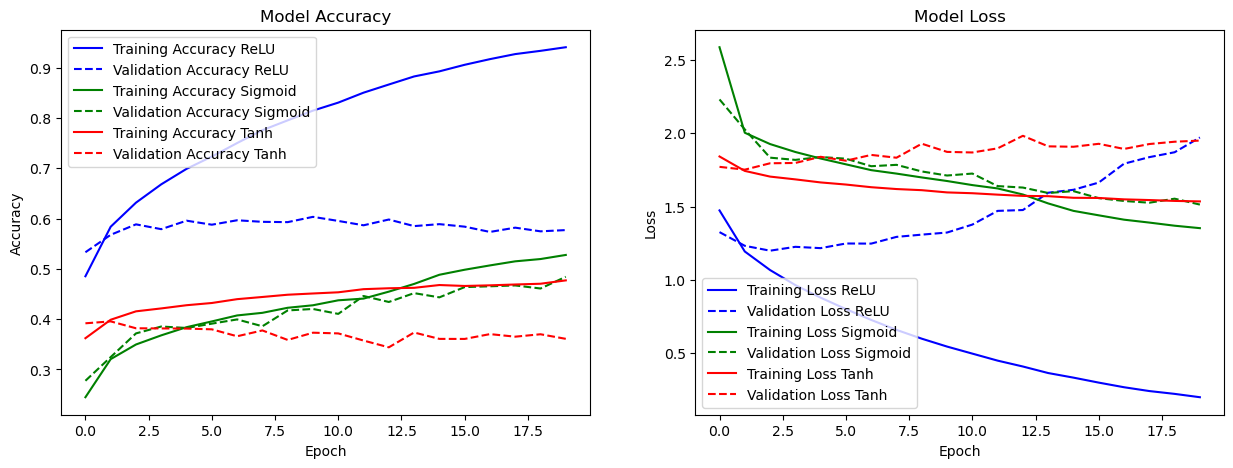

In [44]:
single_layer_model_activation_history = evaluate_activation_functions(single_layer_model)

The graph shows that the ReLU activation function performs better than the Sigmoid and Tanh activation functions as the validation accuracy is much higher across all epochs. ReLU is generally considered to be better than sigmoid and tanh for image classification as it's computationally efficient and avoids the vanishing gradient problem, although it will be worth performing this comparison on another model to see if ReLU is consistently the better performing activation function for classification of the CIFAR-10 dataset. Another observation that can be made is that ReLU is more likely to overfit the training data than Sigmoid and Tanh, as evidenced by its higher training accuracy and validation loss which may be because ReLU converges faster than Sigmoid and Tanh.

### Compare different optimisers <a class="anchor" id="compare-optimisers"></a>

To compare the effect of different optimisers on the single-layer model, we can use the `evaluate_optimisers` function defined earlier.

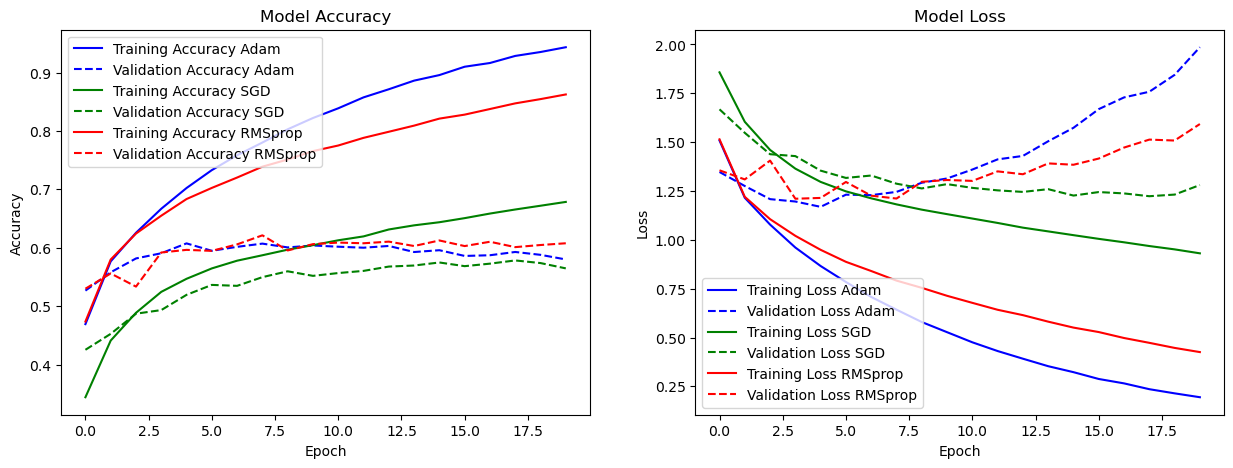

In [45]:
single_layer_model_optimiser_history = evaluate_optimisers(single_layer_model)

This graph shows that the effect Adam and RMSprop has on the model is fairly similar, with the model using SGD performing slightly worse. Since Adam and RMSprop are both adaptive optimisers, they can adapt the learning rate during training which suggests why they may converge faster than SGD. Throughout the training, both Adam and RMSprop perform better than the other at some point, but the differences are not significant. Therefore, the Adam optimiser will continue to be used for the rest of the comparisons with this model, although it will be worth performing this comparison on the multi-layer model to see which optimiser consistently produces the best model.

### Compare different learning rates <a class="anchor" id="compare-learning-rates"></a>

The next comparison to make is between different learning rates. As the model was overfitting the training data, choosing a different learning rate may improve the performance. To compare the effect of different learning rates, we can use the `evaluate_learning_rates` function defined earlier.

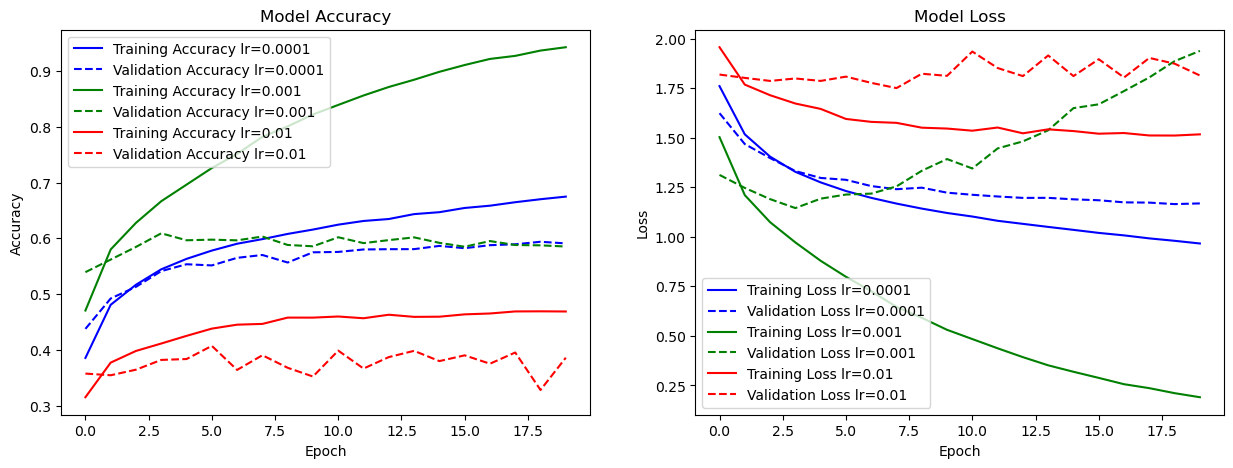

In [17]:
single_layer_model_learning_rate_history = evaluate_learning_rates(single_layer_model)

From this graph, we can see that a learning rate of 0.0001 is the best performing. This is because a learning rate of 0.01 is too high so the model is not able to converge on a good solution, and a learning rate of 0.001 overfits the training data. A learning rate of 0.0001 is less prone to overfitting the training data for this architecture as the training accuracy/loss is closer to the validation accuracy/loss - it will be interesting to test whether this is the case with another model architecture.

### Compare different convolutional kernel sizes and number of filters <a class="anchor" id="compare-kernel-sizes"></a>

The last couple of experiments to perform are comparing different kernel sizes and numbers of filters. We can use the `evaluate_kernel_sizes` and `evaluate_num_of_filters` functions defined earlier to compare the performance of different configurations.

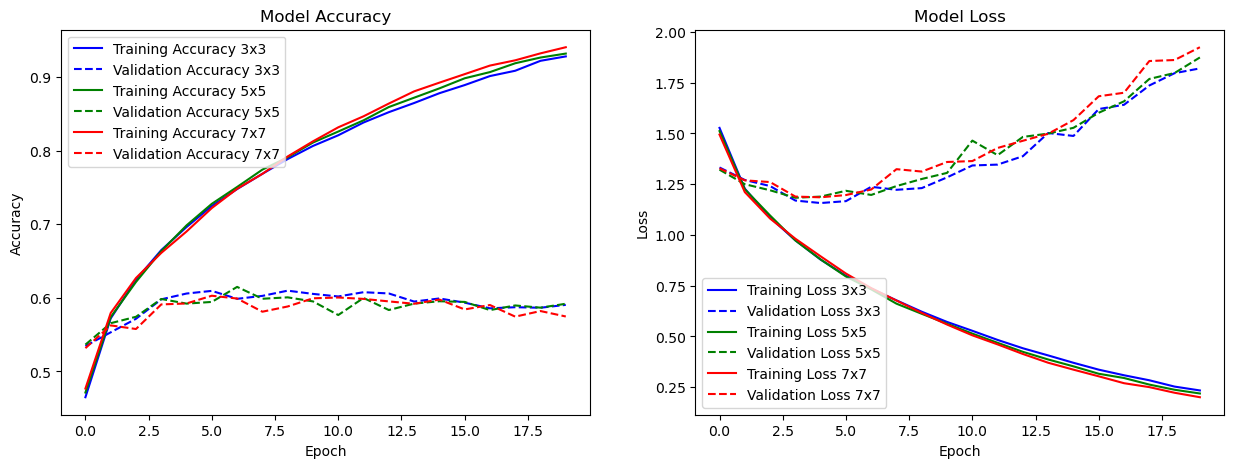

In [18]:
single_layer_kernel_size_history = evaluate_kernel_sizes(single_layer_model)

The results show that modifying the kernel size has little effect on the performance of the model which could be because the CIFAR-10 dataset is pretty simple, so it doesn't need bigger kernels to learn more complex features. Since the 3x3 kernel size had the quickest training time due to less parameters, it can be seen as being the best performing.

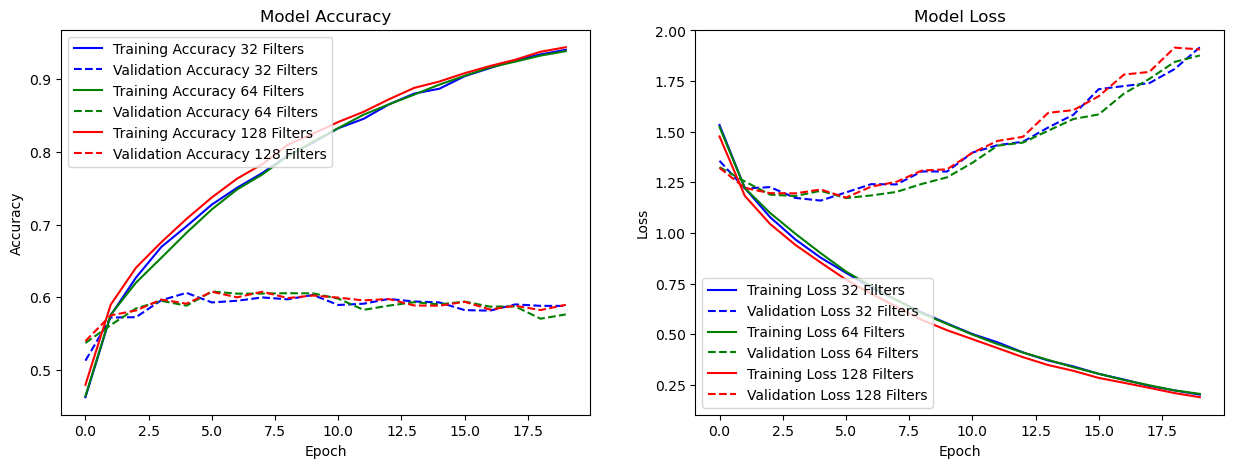

In [19]:
single_layer_number_of_filters_history = evaluate_num_of_filters(single_layer_model)

Similar to the kernel size, the number of filters didn't really affect the performance of the model, which may also have been because the CIFAR-10 dataset contains simple images. Therefore, 32 filters will be used in the final model.

### Create tuned single-layer model <a class="anchor" id="tuned-single-layer-model"></a>

Using the results from the previous experiments, we can create a single-layer model using the parameters that showed the best performance:
- ReLU activation function
- Adam optimiser
- Learning rate of 0.0001
- Kernel size of 3x3
- Number of filters of 32

In [24]:
single_layer_model_tuned = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    Flatten(),
    Dense(10, activation='softmax')
])
single_layer_model_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy']
                                 )

Epoch 1/100
625/625 [==============================] - 2s 3ms/step - loss: 1.7912 - accuracy: 0.3704 - val_loss: 1.6192 - val_accuracy: 0.4390
Epoch 2/100
625/625 [==============================] - 1s 2ms/step - loss: 1.5466 - accuracy: 0.4669 - val_loss: 1.5195 - val_accuracy: 0.4724
Epoch 3/100
625/625 [==============================] - 1s 2ms/step - loss: 1.4474 - accuracy: 0.5011 - val_loss: 1.4457 - val_accuracy: 0.4927
Epoch 4/100
625/625 [==============================] - 1s 2ms/step - loss: 1.3799 - accuracy: 0.5255 - val_loss: 1.4012 - val_accuracy: 0.5111
Epoch 5/100
625/625 [==============================] - 1s 2ms/step - loss: 1.3300 - accuracy: 0.5433 - val_loss: 1.3580 - val_accuracy: 0.5324
Epoch 6/100
625/625 [==============================] - 1s 2ms/step - loss: 1.2910 - accuracy: 0.5579 - val_loss: 1.3333 - val_accuracy: 0.5334
Epoch 7/100
625/625 [==============================] - 1s 2ms/step - loss: 1.2586 - accuracy: 0.5695 - val_loss: 1.2981 - val_accuracy: 0.5543

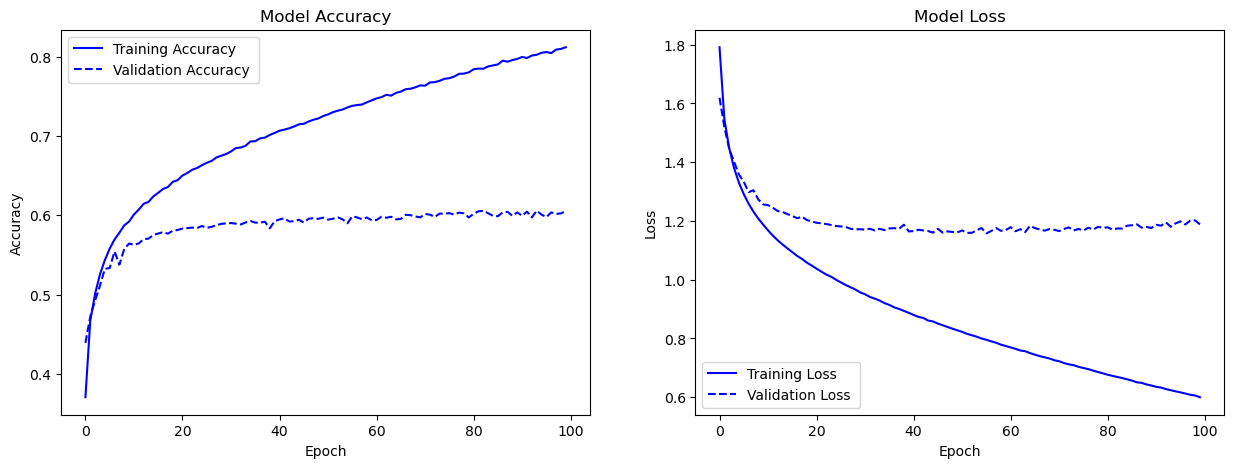

In [25]:
single_layer_model_tuned_history = single_layer_model_tuned.fit(x_train, y_train, batch_size=64, epochs=100,
                                                                validation_data=(x_val, y_val))
plot_training_accuracy_loss([single_layer_model_tuned_history])

Test accuracy: 0.5909000039100647
Test loss: 1.2170588970184326


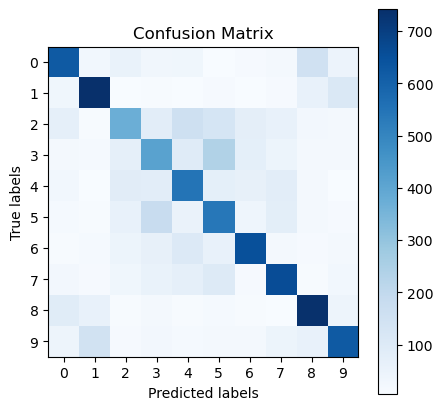

In [26]:
test_model(single_layer_model_tuned)

The tuned single-layer model has shown slightly better performance over the initial one with an increase of approximately 4% on the testing set, with a large reduction in the validation loss showing that the model is not overfitting the training data as much as before. The confusion matrix also reinforces that the tuned model is performing better as it has reduced the number of misclassifications of class 3 (cats) as class 5 (dogs) and vice versa.

## Build a more complex neural network <a class="anchor" id="more-complex-model"></a>

A more complex architecture will now be used consisting of 3 convolutional layers with max pooling layers between them, followed by a flatten layer and 2 dense layers.

Model architecture: *TensorFlow. Convolutional Neural Networks (CNN) - TensorFlow Core. [online] Available at: https://www.tensorflow.org/tutorials/images/cnn [Accessed 6 March 2023]*.

- The first convolutional layer has 32 filters of size 3x3, whereas the second and third convolutional layers have 64 filters of size 3x3.
- The max pooling layers inbetween each convolutional layer has a pool size of 2x2.
- The output of the final convolutional layer is flattened and passed to a dense layer with 64 neurons.
- The final dense layer has 10 neurons and a softmax activation function, where each neuron corresponds to a class.

Again, start by using:
- ReLU activation function for the convolutional layers (as it is a good default choice)
- Adam optimiser (as it is a good default choice)

For this architecture, similar experiments will be performed to the single-layer one to compare the effect of different parameters.

In [66]:
multi_layer_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
multi_layer_model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy']
                          )

Train the model for 100 epochs with a batch size of 64 on the training data and evaluate the model on the validation data. Since this model has more depth and more filters, it should be able to learn more complex features and therefore is expected to perform better than the single-layer model.

Epoch 1/100
625/625 [==============================] - 3s 4ms/step - loss: 1.5564 - accuracy: 0.4347 - val_loss: 1.2856 - val_accuracy: 0.5382
Epoch 2/100
625/625 [==============================] - 2s 3ms/step - loss: 1.1663 - accuracy: 0.5880 - val_loss: 1.1245 - val_accuracy: 0.5980
Epoch 3/100
625/625 [==============================] - 2s 3ms/step - loss: 0.9995 - accuracy: 0.6525 - val_loss: 0.9941 - val_accuracy: 0.6503
Epoch 4/100
625/625 [==============================] - 2s 3ms/step - loss: 0.8767 - accuracy: 0.6918 - val_loss: 0.8896 - val_accuracy: 0.6910
Epoch 5/100
625/625 [==============================] - 2s 3ms/step - loss: 0.7915 - accuracy: 0.7241 - val_loss: 0.8495 - val_accuracy: 0.7015
Epoch 6/100
625/625 [==============================] - 2s 3ms/step - loss: 0.7145 - accuracy: 0.7519 - val_loss: 0.8212 - val_accuracy: 0.7151
Epoch 7/100
625/625 [==============================] - 2s 3ms/step - loss: 0.6517 - accuracy: 0.7733 - val_loss: 0.8386 - val_accuracy: 0.7092

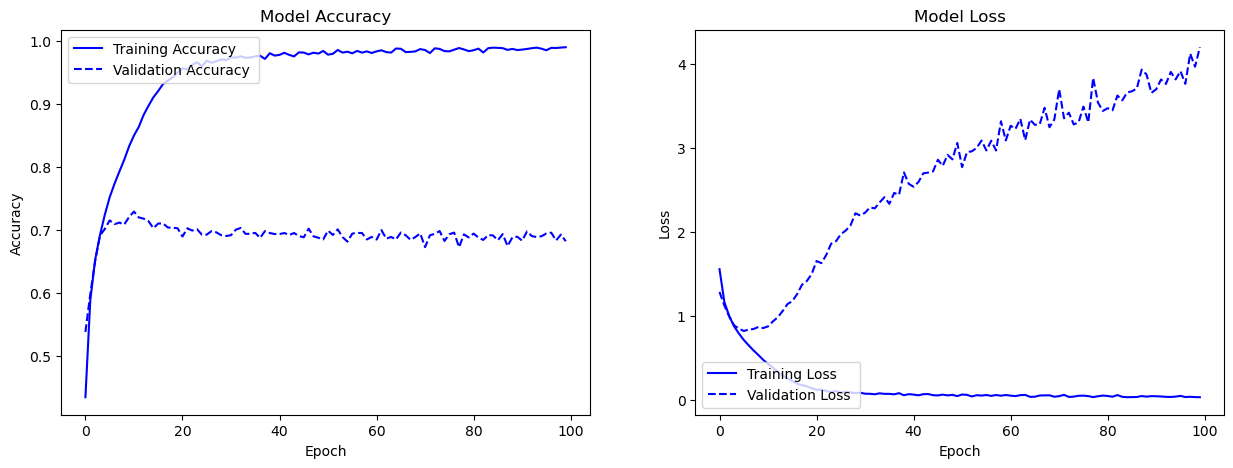

In [67]:
multi_layer_model_history = multi_layer_model.fit(x_train, y_train, batch_size=64, epochs=100,
                                                  validation_data=(x_val, y_val))
plot_training_accuracy_loss([multi_layer_model_history])

Test accuracy: 0.6722000241279602
Test loss: 4.565126895904541


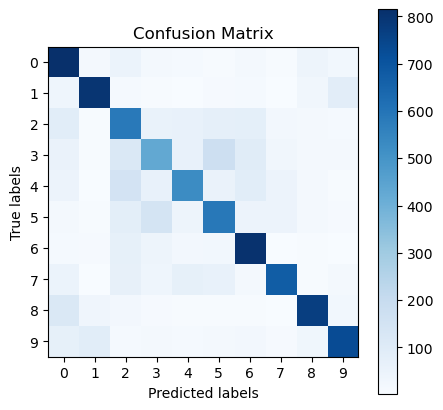

In [68]:
test_model(multi_layer_model)

As expected, this model performs quite a bit better than the single layer model, as evidenced by greater test accuracy. However, similar to the single layer model, this model is overfitting the training data. As a result, we will also do an early stop after 20 epochs to prevent overfitting from skewing the results in each of the experiments.

### Compare different activation functions <a class="anchor" id="complex-compare-activation-functions"></a>

Similar to the single layer model, we will compare the performance of the ReLU, sigmoid and tanh activation functions using the `evaluate_activation_functions` method.

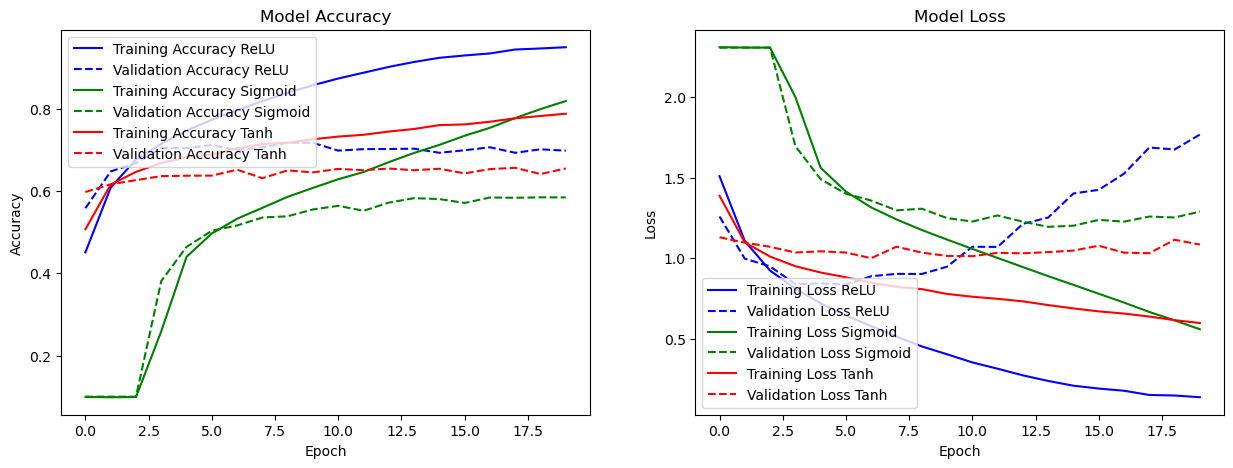

In [30]:
multi_layer_model_activation_history = evaluate_activation_functions(multi_layer_model)

Similar to the single-layer model, a multi-layer model that used ReLU showed better performance than the using the other activation functions - although it did also overfit the training data again. The model using the Sigmoid activation function didn't improve its accuracy for a few epochs which could have been because it got stuck in a local minima, whilst it also showed Tanh to be slightly worse than ReLU.

### Compare different optimisers <a class="anchor" id="complex-compare-optimisers"></a>

Next we will compare the performance of the Adam, RMSProp and SGD optimisers using the `evaluate_optimisers` method, and how similar the results are to the single-layer model.

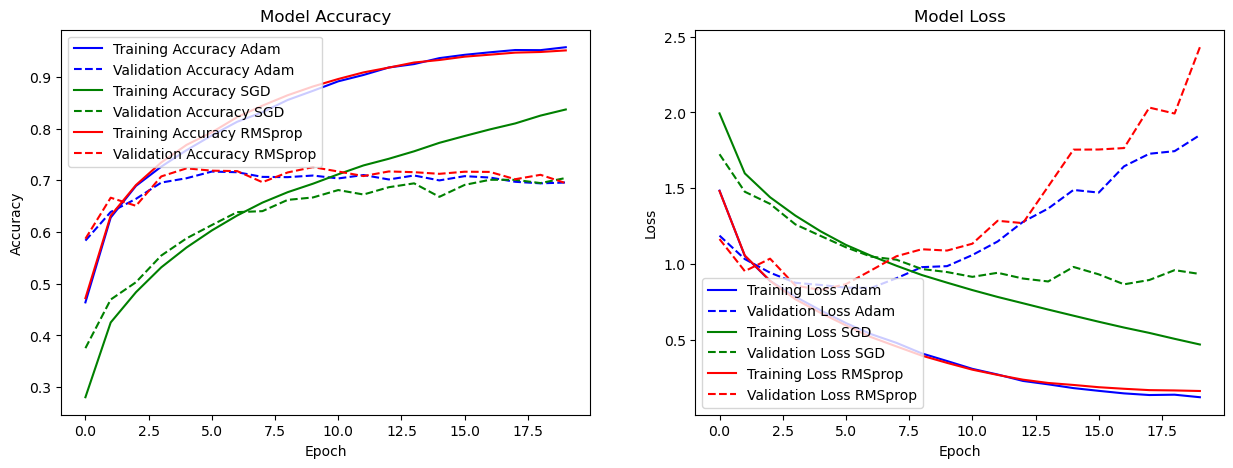

In [32]:
multi_layer_model_optimiser_history = evaluate_optimisers(multi_layer_model)

The results show that by the 20th epoch, the accuracy of each of the models is fairly similar. As with the single-layer model, the Adam and RMSprop optimisers meant that the model was able to converge faster than the SGD optimiser. However, both Adam and RMSprop overfit the training data more strongly than SGD, therefore modifying the learning rate may help control this.

### Compare different learning rates <a class="anchor" id="complex-compare-learning-rates"></a>

For the single-layer model, it was observed that a learning rate of 0.0001 gave the best performance so it will be interesting to see whether a similar learning rate will be optimal for this model.

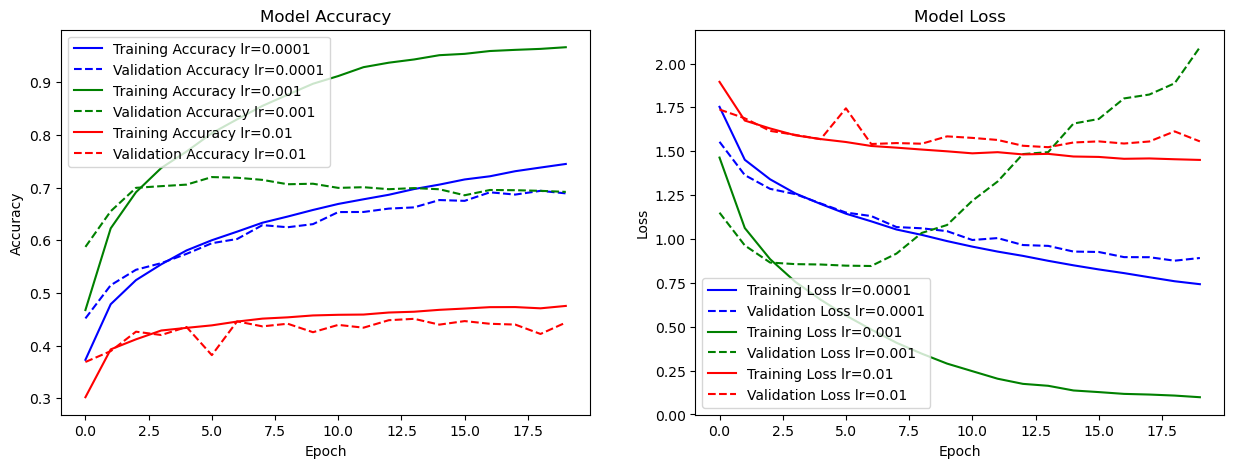

In [69]:
multi_layer_model_learning_rate_history = evaluate_learning_rates(multi_layer_model)

The results seen with different learning rates on this model are similar to the results seen with the single-layer model - learning rates of 0.0001 and 0.001 have similar performance on the validation set by the 20th epoch, while the learning rate of 0.01 has much worse performance. Again, this is likely due to the fact that the learning rate is too high, and the model is unable to converge to a good solution. Also similar to the simple model, a learning rate of 0.001 overfits on the training set as the training accuracy is much higher than the validation accuracy, making 0.0001 the best learning rate.

### Compare different convolutional kernel sizes and number of filters <a class="anchor" id="complex-compare-kernel-sizes"></a>

Since experimenting with the kernel sizes gave similar results to the single-layer model, we will now compare the performance of different kernel sizes for this model.

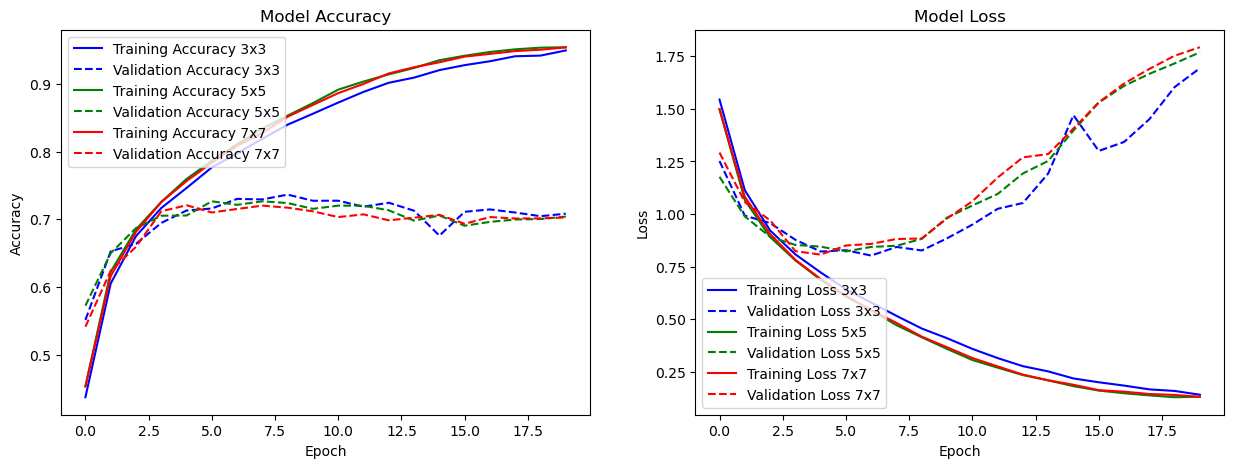

In [34]:
multi_layer_model_kernel_size_history = evaluate_kernel_sizes(multi_layer_model)

Again, the results are similar to the single-layer model in which all the kernel sizes had very similar training and validation accuracy/loss. Therefore, a kernel size of 3x3 will be used for the rest of the experiments since the training time is faster. Next a comparison of the number of filters in each layer will be performed, with an additional test of increasing the number of filters in each layer which wasn't possible with the single-layer model.

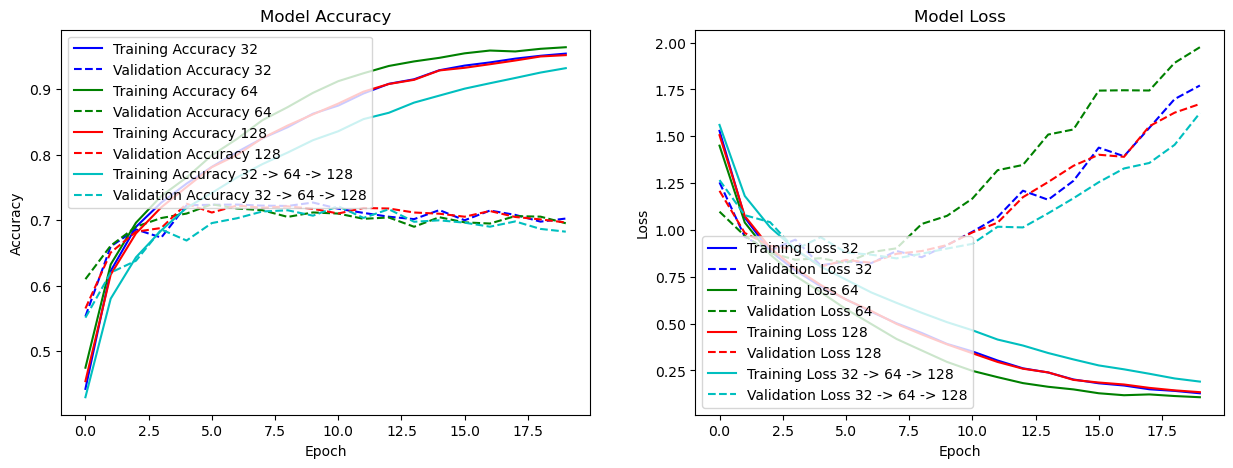

In [35]:
increasing_filters = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

multi_layer_model_number_of_filters_history = evaluate_num_of_filters(multi_layer_model,
                                                                      custom_model=increasing_filters,
                                                                      custom_filters='32 -> 64 -> 128')

Similar to the single-layer model, these results show that increasing the number of filters does not have much effect on the performance of the model, nor does progressively increasing the number of filters in each layer of the model. This is likely because the model is able to learn the features it needs with 32 filters so adding more filters doesn't improve the performance.

### Create tuned multi-layer model <a class="anchor" id="tuned-multi-layer-model"></a>

Using the results from the previous experiments, we will now create the multi-layer model with the following configuration:
- activation function: ReLU
- optimiser: Adam
- learning rate: 0.0001
- filter size: 3x3
- filter numbers: 32

Since this is fairly similar to the initial multi-layer model configuration, effectively we will be testing the difference in learning rate on the multi-layer model. For consistency, it will be trained for 100 epochs.

In [36]:
multi_layer_model_tuned = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
multi_layer_model_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                loss='categorical_crossentropy',
                                metrics=['accuracy']
                                )

Epoch 1/100
1250/1250 [==============================] - 5s 3ms/step - loss: 1.9599 - accuracy: 0.2885 - val_loss: 1.7398 - val_accuracy: 0.3738
Epoch 2/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6567 - accuracy: 0.4054 - val_loss: 1.5894 - val_accuracy: 0.4271
Epoch 3/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.5452 - accuracy: 0.4414 - val_loss: 1.5035 - val_accuracy: 0.4596
Epoch 4/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4768 - accuracy: 0.4670 - val_loss: 1.4580 - val_accuracy: 0.4769
Epoch 5/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4246 - accuracy: 0.4862 - val_loss: 1.4442 - val_accuracy: 0.4865
Epoch 6/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.3856 - accuracy: 0.5024 - val_loss: 1.3797 - val_accuracy: 0.5052
Epoch 7/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.3516 - accuracy: 0.5179 - val_loss: 1.3510 - val_ac

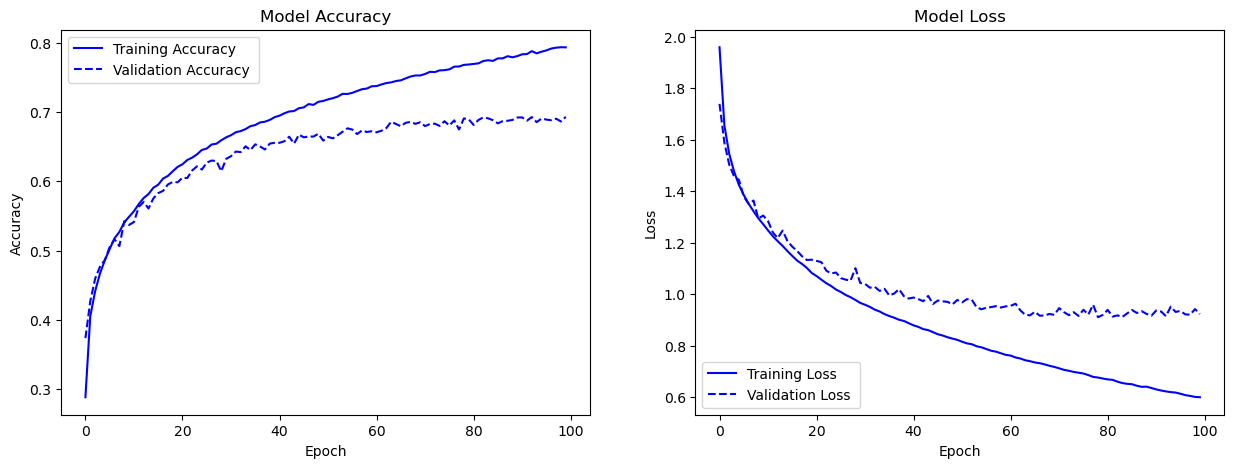

In [37]:
multi_layer_model_tuned_history = multi_layer_model_tuned.fit(x_train, y_train, epochs=100,
                                                              validation_data=(x_val, y_val))
plot_training_accuracy_loss([multi_layer_model_tuned_history])

Test accuracy: 0.6980999708175659
Test loss: 0.9256613254547119


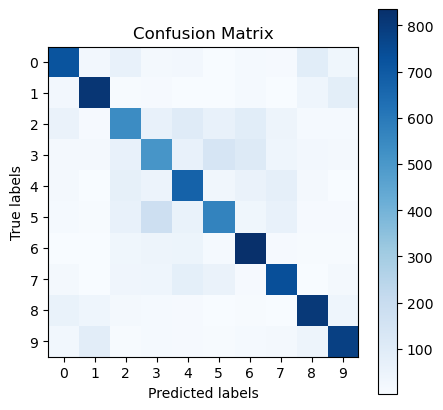

In [38]:
test_model(multi_layer_model_tuned)

It is clear to see that using a learning rate of 0.0001 has improved the performance of the model as the test accuracy has increased by approximately 3% compared to the initial model. This is likely due to the fact that the learning rate is lower, and the model is able to converge to a better solution. It is also clear that the amount the model overfits on the training set has decreased as the training accuracy is now closer to the validation accuracy and the validation loss is lower.

## Build a Deep Convolutional Neural Network with VGG architecture <a class="anchor" id="build-deep-cnn"></a>

Since we've built a simple CNN and a more complex CNN, let's now experiment building a deep CNN inspired by the VGG architecture which is a popular architecture for image classification. CNN's with VGG architecture consist of a stack of VGG blocks followed by a fully connected layer. A VGG block consists of 2 convolutional layers with 3x3 filters, followed by a max pooling layer with a 2x2 filter.

Architecture taken from: *Simonyan, K., & Zisserman, A. (2015). Very deep convolutional networks for large-scale image recognition. In Proceedings of the International Conference on Learning Representations (ICLR)*.

In [39]:
# Create a function to create a VGG block with a custom number of filters
def VGGBlock(filters=32, input_shape=None):
    if input_shape is None:
        return Sequential([
            Conv2D(filters, (3, 3), activation='relu', padding='same'),
            Conv2D(filters, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2))
        ])
    else:
        return Sequential([
            Conv2D(filters, (3, 3), activation='relu', padding='same', input_shape=input_shape),
            Conv2D(filters, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2))
        ])

The first set of configurations that will be tested is the difference in performance between models with one, two and three VGG blocks. As is the case with the VGG architecture, the number of filters in each layer will be increased by a factor of 2 in each VGG block, and the ReLU activation function will be used.

### Single VGG Block <a class="anchor" id="single-vgg-block"></a>

The first deep CNN we will build will consist of a single VGG block. The output is flattened and passed to a Dense layer with 128 neurons and a ReLU activation function. The output is then passed to another Dense layer with 10 neurons and a softmax activation function.

In [40]:
vgg_single_block_model = Sequential([
    VGGBlock(filters=32, input_shape=(32, 32, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_single_block_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

Train the model for 100 epochs with a batch size of 64 on the training data and evaluate the model on the validation data. The accuracy for this model should be higher than the single-layer neural network, but lower than the multi-layer model since this model with one VGG block is less complex than the multi-layer model.

Epoch 1/100
625/625 [==============================] - 3s 3ms/step - loss: 1.3926 - accuracy: 0.5034 - val_loss: 1.1181 - val_accuracy: 0.6011
Epoch 2/100
625/625 [==============================] - 2s 3ms/step - loss: 1.0050 - accuracy: 0.6507 - val_loss: 1.0011 - val_accuracy: 0.6532
Epoch 3/100
625/625 [==============================] - 2s 3ms/step - loss: 0.8593 - accuracy: 0.7006 - val_loss: 0.9403 - val_accuracy: 0.6745
Epoch 4/100
625/625 [==============================] - 2s 3ms/step - loss: 0.7454 - accuracy: 0.7419 - val_loss: 0.9217 - val_accuracy: 0.6806
Epoch 5/100
625/625 [==============================] - 2s 3ms/step - loss: 0.6446 - accuracy: 0.7755 - val_loss: 0.9394 - val_accuracy: 0.6806
Epoch 6/100
625/625 [==============================] - 2s 3ms/step - loss: 0.5409 - accuracy: 0.8107 - val_loss: 0.9847 - val_accuracy: 0.6788
Epoch 7/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4360 - accuracy: 0.8494 - val_loss: 1.0238 - val_accuracy: 0.6857

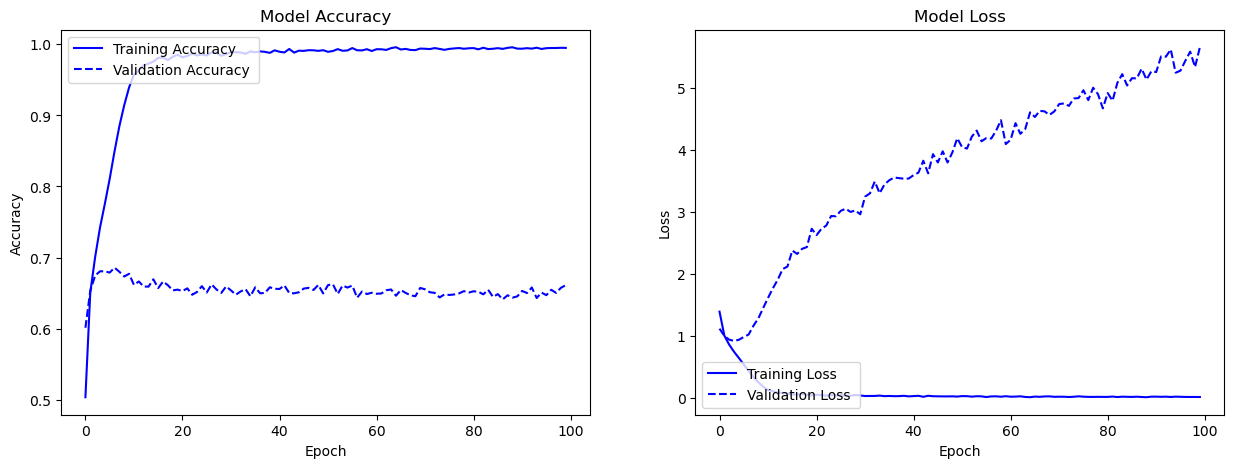

In [41]:
vgg_single_block_model_history = vgg_single_block_model.fit(x_train, y_train, batch_size=64, epochs=100,
                                                            validation_data=(x_val, y_val))
plot_training_accuracy_loss([vgg_single_block_model_history])

Test accuracy: 0.6521000266075134
Test loss: 5.929806709289551


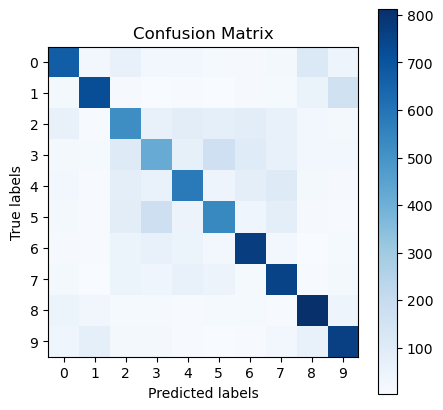

In [42]:
test_model(vgg_single_block_model)

As expected, the accuracy is higher than the single-layer neural network but lower than the multi-layer one. This is reflected in the confusion matrix, where the model is much better at predicting the correct class for each image. However, the model is rapidly overfitting the validation data set after a few epochs which may be because the model is too complex for the small dataset.

### Double VGG Block <a class="anchor" id="double-vgg-block"></a>

Lets try adding another VGG block with 64 filters to the model and see how it affects the accuracy.

In [43]:
vgg_double_block_model = Sequential([
    VGGBlock(filters=32, input_shape=(32, 32, 3)),
    VGGBlock(filters=64),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_double_block_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 3s 5ms/step - loss: 1.4514 - accuracy: 0.4751 - val_loss: 1.1454 - val_accuracy: 0.5911
Epoch 2/100
625/625 [==============================] - 3s 4ms/step - loss: 0.9957 - accuracy: 0.6483 - val_loss: 0.9074 - val_accuracy: 0.6737
Epoch 3/100
625/625 [==============================] - 3s 4ms/step - loss: 0.8092 - accuracy: 0.7153 - val_loss: 0.8919 - val_accuracy: 0.6904
Epoch 4/100
625/625 [==============================] - 3s 4ms/step - loss: 0.6800 - accuracy: 0.7605 - val_loss: 0.7670 - val_accuracy: 0.7300
Epoch 5/100
625/625 [==============================] - 3s 4ms/step - loss: 0.5751 - accuracy: 0.7988 - val_loss: 0.8252 - val_accuracy: 0.7191
Epoch 6/100
625/625 [==============================] - 2s 4ms/step - loss: 0.4690 - accuracy: 0.8337 - val_loss: 0.8698 - val_accuracy: 0.7121
Epoch 7/100
625/625 [==============================] - 2s 4ms/step - loss: 0.3787 - accuracy: 0.8668 - val_loss: 0.8133 - val_accuracy: 0.7502

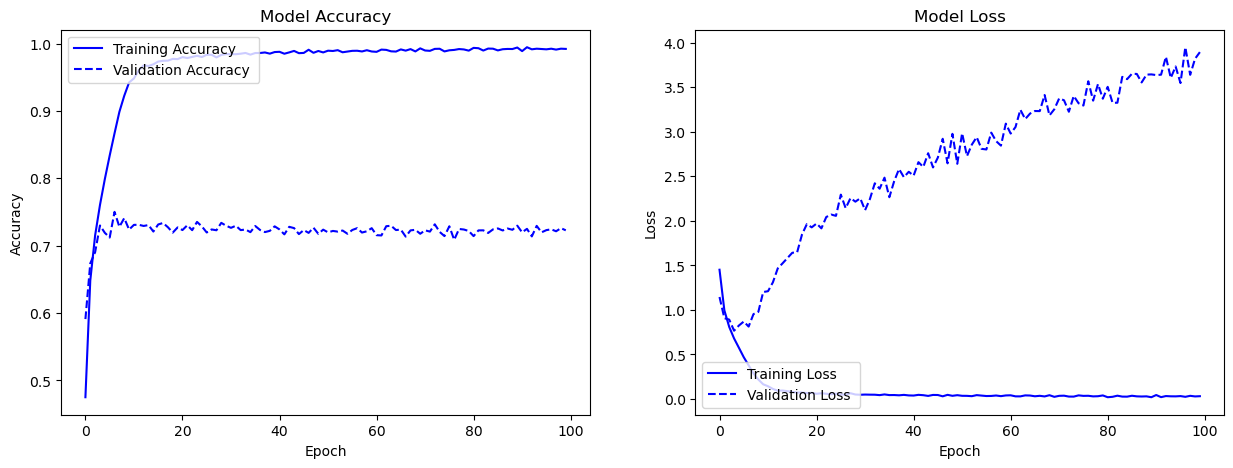

In [44]:
vgg_double_block_model_history = vgg_double_block_model.fit(x_train, y_train, batch_size=64, epochs=100,
                                                            validation_data=(x_val, y_val))
plot_training_accuracy_loss([vgg_double_block_model_history])

Test accuracy: 0.7135000228881836
Test loss: 4.107185363769531


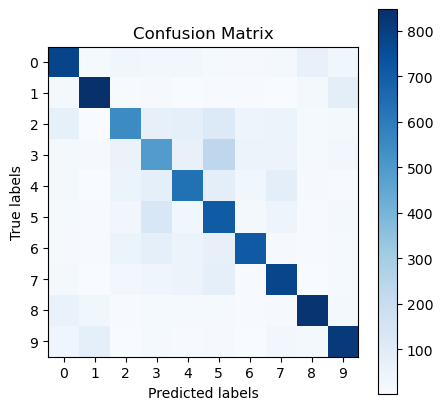

In [45]:
test_model(vgg_double_block_model)

The accuracy has improved by a reasonable amount over the single VGG block model, so it is plausible that adding another VGG block will improve the accuracy even further. This time, lets add a block with 128 filters.

### Triple VGG Block <a class="anchor" id="triple-vgg-block"></a>

In [46]:
vgg_triple_block_model = Sequential([
    VGGBlock(filters=32, input_shape=(32, 32, 3)),
    VGGBlock(filters=64),
    VGGBlock(filters=128),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 4s 5ms/step - loss: 1.5794 - accuracy: 0.4160 - val_loss: 1.2655 - val_accuracy: 0.5387
Epoch 2/100
625/625 [==============================] - 3s 5ms/step - loss: 1.0729 - accuracy: 0.6183 - val_loss: 0.9600 - val_accuracy: 0.6538
Epoch 3/100
625/625 [==============================] - 3s 5ms/step - loss: 0.8405 - accuracy: 0.7030 - val_loss: 0.8097 - val_accuracy: 0.7142
Epoch 4/100
625/625 [==============================] - 3s 5ms/step - loss: 0.6910 - accuracy: 0.7564 - val_loss: 0.7877 - val_accuracy: 0.7288
Epoch 5/100
625/625 [==============================] - 3s 5ms/step - loss: 0.5785 - accuracy: 0.7971 - val_loss: 0.7216 - val_accuracy: 0.7494
Epoch 6/100
625/625 [==============================] - 3s 5ms/step - loss: 0.4786 - accuracy: 0.8318 - val_loss: 0.7337 - val_accuracy: 0.7512
Epoch 7/100
625/625 [==============================] - 3s 5ms/step - loss: 0.3888 - accuracy: 0.8631 - val_loss: 0.7706 - val_accuracy: 0.7594

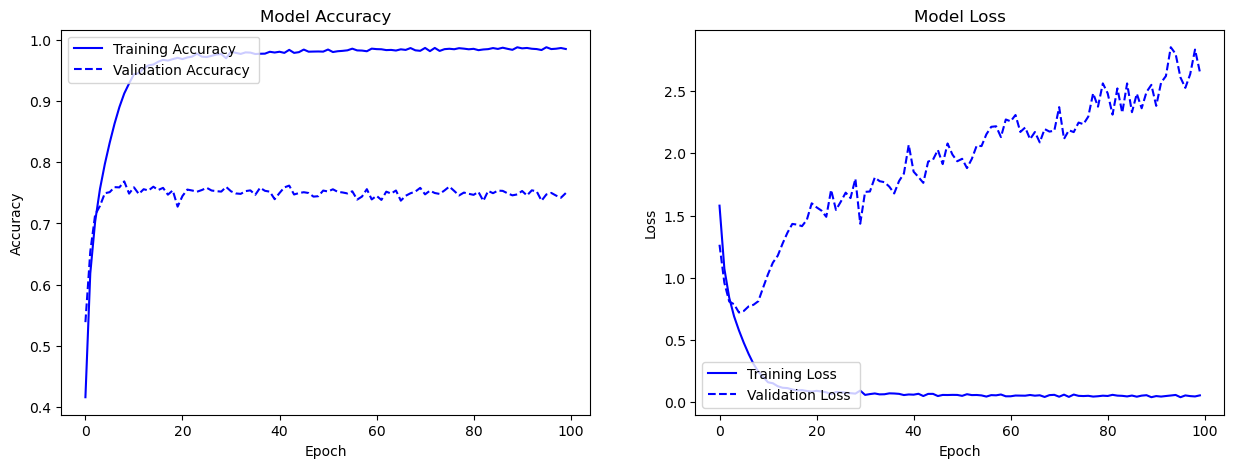

In [47]:
vgg_triple_block_model_history = vgg_triple_block_model.fit(x_train, y_train, batch_size=64, epochs=100,
                                                            validation_data=(x_val, y_val))
plot_training_accuracy_loss([vgg_triple_block_model_history])

Test accuracy: 0.7448999881744385
Test loss: 2.814802885055542


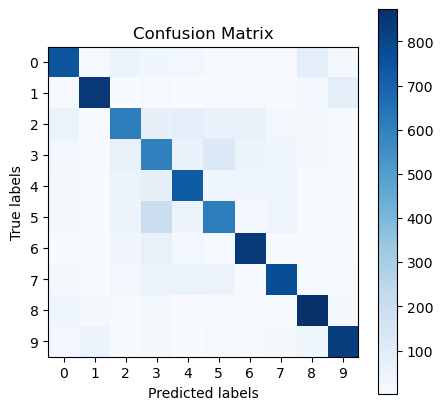

In [48]:
test_model(vgg_triple_block_model)

The accuracy has improved over the double VGG block model, but not by as much as the difference between the single and double VGG block models. It is therefore likely that adding more VGG blocks will not necessarily improve the accuracy of the model i.e. we will reach a threshold where adding more VGG blocks will not improve the accuracy of the model, but instead just increase the training time because of the increase in the number of parameters. Like the other architectures used, we can see that all the models were rapidly overfitting the training data after 5-10 epochs, so we will next explore different types of regularisation to prevent this.

### Model Regularisation <a class="anchor" id="model-regularisation"></a>

In each of the graphs displaying the loss of each model, the validation loss is shown to decrease for several epochs before rapidly increasing again. This signals that the models are overfitting the training data which means we need to add regularisation to the model. In this section, we will explore different types of regularisation on the triple VGG block model and compare the results.

The different types of regularisation that will be compared are: dropout regularisation, batch normalisation and data augmentation.

The first type that will be explored is dropout regularisation which is a technique where neurons are selected at random and dropped out of the network during training. This reduces the chance of overfitting by preventing specific neurons dominating the training process and leads to better generalisation. Progressively increasing the dropout rate in each VGG block will be explored to see how it affects the accuracy of the model (this is a popular technique as overfitting is more likely to occur in more complex layers).

In [49]:
vgg_triple_block_model_dropout = Sequential([
    VGGBlock(filters=32, input_shape=(32, 32, 3)),
    Dropout(0.2),
    VGGBlock(filters=64),
    Dropout(0.3),
    VGGBlock(filters=128),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_model_dropout.compile(optimizer='adam',
                                       loss='categorical_crossentropy',
                                       metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 4s 6ms/step - loss: 1.6706 - accuracy: 0.3814 - val_loss: 1.3302 - val_accuracy: 0.5215
Epoch 2/100
625/625 [==============================] - 4s 6ms/step - loss: 1.2153 - accuracy: 0.5601 - val_loss: 1.0698 - val_accuracy: 0.6197
Epoch 3/100
625/625 [==============================] - 4s 6ms/step - loss: 1.0290 - accuracy: 0.6314 - val_loss: 0.9120 - val_accuracy: 0.6727
Epoch 4/100
625/625 [==============================] - 4s 6ms/step - loss: 0.9142 - accuracy: 0.6764 - val_loss: 0.8209 - val_accuracy: 0.7089
Epoch 5/100
625/625 [==============================] - 3s 6ms/step - loss: 0.8287 - accuracy: 0.7049 - val_loss: 0.7381 - val_accuracy: 0.7386
Epoch 6/100
625/625 [==============================] - 3s 6ms/step - loss: 0.7650 - accuracy: 0.7319 - val_loss: 0.6955 - val_accuracy: 0.7542
Epoch 7/100
625/625 [==============================] - 4s 6ms/step - loss: 0.7117 - accuracy: 0.7486 - val_loss: 0.7086 - val_accuracy: 0.7457

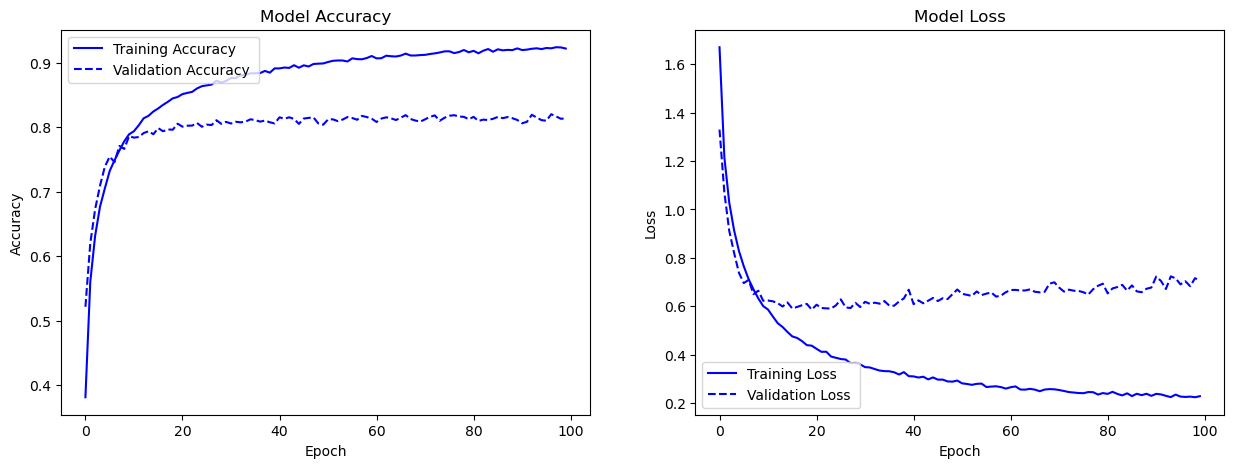

In [50]:
vgg_triple_block_model_dropout_history = vgg_triple_block_model_dropout.fit(x_train, y_train, batch_size=64, epochs=100,
                                                                            validation_data=(x_val, y_val))
plot_training_accuracy_loss([vgg_triple_block_model_dropout_history])

Test accuracy: 0.8101000189781189
Test loss: 0.7434622049331665


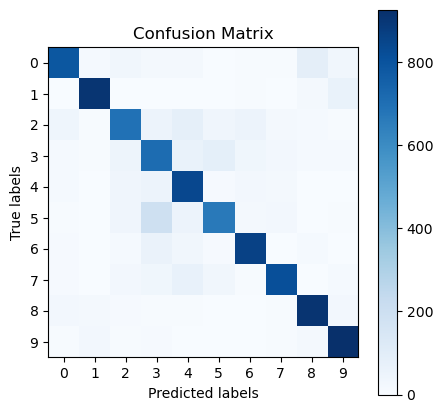

In [51]:
test_model(vgg_triple_block_model_dropout)

As can be seen from the test accuracy, regularisation via dropout has improved the performance of the model. This is also reflected in the confusion matrix, where more labels were correctly predicted. There is much less overfitting of the training data too because the validation loss is lower than before and the training accuracy is closer to the validation accuracy.

Next, let's create a triple VGG block model with batch normalisation and compare the results. Batch normalisation regulates the values of the neurons in each layer by normalising it to a mean of 0 and a standard deviation of 1 which prevents overfitting by stopping a value from becoming too large or small.

In [52]:
from tensorflow.keras.layers import BatchNormalization


def VGGBlockBatchNormalisation(filters, input_shape=None):
    if input_shape is None:
        return Sequential([
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        ])
    else:
        return Sequential([
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape),
            BatchNormalization(),
            Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        ])

In [53]:
vgg_triple_block_batch_normalisation = Sequential([
    VGGBlockBatchNormalisation(filters=32, input_shape=(32, 32, 3)),
    VGGBlockBatchNormalisation(filters=64),
    VGGBlockBatchNormalisation(filters=128),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_batch_normalisation.compile(optimizer='adam',
                                             loss='categorical_crossentropy',
                                             metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 5s 7ms/step - loss: 1.2851 - accuracy: 0.5444 - val_loss: 1.0229 - val_accuracy: 0.6475
Epoch 2/100
625/625 [==============================] - 4s 6ms/step - loss: 0.8238 - accuracy: 0.7092 - val_loss: 0.8753 - val_accuracy: 0.6919
Epoch 3/100
625/625 [==============================] - 4s 6ms/step - loss: 0.6366 - accuracy: 0.7760 - val_loss: 0.8000 - val_accuracy: 0.7291
Epoch 4/100
625/625 [==============================] - 4s 7ms/step - loss: 0.5157 - accuracy: 0.8208 - val_loss: 0.6711 - val_accuracy: 0.7720
Epoch 5/100
625/625 [==============================] - 4s 6ms/step - loss: 0.4056 - accuracy: 0.8598 - val_loss: 0.8576 - val_accuracy: 0.7340
Epoch 6/100
625/625 [==============================] - 4s 6ms/step - loss: 0.3168 - accuracy: 0.8879 - val_loss: 0.7103 - val_accuracy: 0.7842
Epoch 7/100
625/625 [==============================] - 4s 6ms/step - loss: 0.2397 - accuracy: 0.9172 - val_loss: 0.8187 - val_accuracy: 0.7671

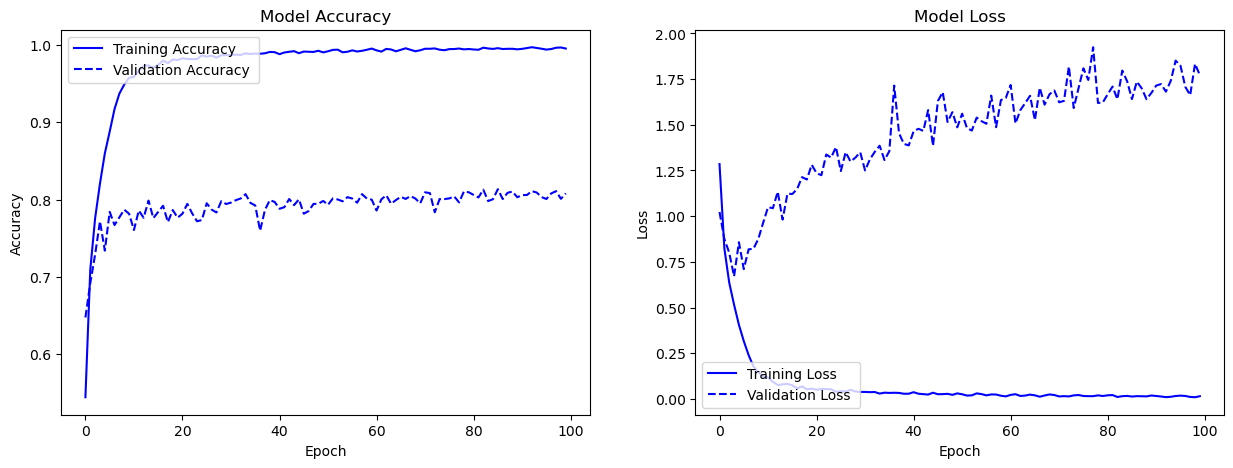

In [54]:
vgg_triple_block_batch_normalisation_history = vgg_triple_block_batch_normalisation.fit(x_train, y_train, batch_size=64,
                                                                                        epochs=100,
                                                                                        validation_data=(x_val, y_val))
plot_training_accuracy_loss([vgg_triple_block_batch_normalisation_history])

Test accuracy: 0.8044000267982483
Test loss: 1.864598274230957


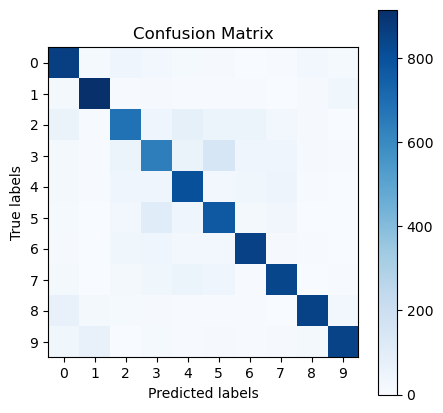

In [55]:
test_model(vgg_triple_block_batch_normalisation)

Similar to dropout regularisation, batch normalisation has improved the performance of the model as the test accuracy is higher. The level of overfitting has been reduced as the validation loss is lower than before, although it is still rapidly overfitting after 5-10 epochs, therefore something that may be worth exploring later is a combination of dropout and batch normalisation.

The final type of regularisation that will be explored is data augmentation. This is a technique where the size of the training dataset is increased by applying random transformations to the images to prevent the model from overfitting the training data. The transformations that will be applied are: rotation, width shift, height shift and horizontal flip using the ImageDataGenerator class from Keras.

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object that will apply the transformations
data_generator = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

In [57]:
vgg_triple_block_data_augmentation = Sequential([
    VGGBlock(filters=32, input_shape=(32, 32, 3)),
    VGGBlock(filters=64),
    VGGBlock(filters=128),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_data_augmentation.compile(optimizer='adam',
                                           loss='categorical_crossentropy',
                                           metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 13s 20ms/step - loss: 1.6925 - accuracy: 0.3733 - val_loss: 1.3148 - val_accuracy: 0.5147
Epoch 2/100
625/625 [==============================] - 12s 19ms/step - loss: 1.2875 - accuracy: 0.5367 - val_loss: 1.1103 - val_accuracy: 0.6092
Epoch 3/100
625/625 [==============================] - 12s 19ms/step - loss: 1.0927 - accuracy: 0.6076 - val_loss: 0.9674 - val_accuracy: 0.6608
Epoch 4/100
625/625 [==============================] - 12s 19ms/step - loss: 0.9675 - accuracy: 0.6582 - val_loss: 0.8386 - val_accuracy: 0.7077
Epoch 5/100
625/625 [==============================] - 12s 20ms/step - loss: 0.8754 - accuracy: 0.6929 - val_loss: 0.8037 - val_accuracy: 0.7165
Epoch 6/100
625/625 [==============================] - 12s 19ms/step - loss: 0.8204 - accuracy: 0.7137 - val_loss: 0.7562 - val_accuracy: 0.7378
Epoch 7/100
625/625 [==============================] - 12s 19ms/step - loss: 0.7629 - accuracy: 0.7342 - val_loss: 0.7700 - val_ac

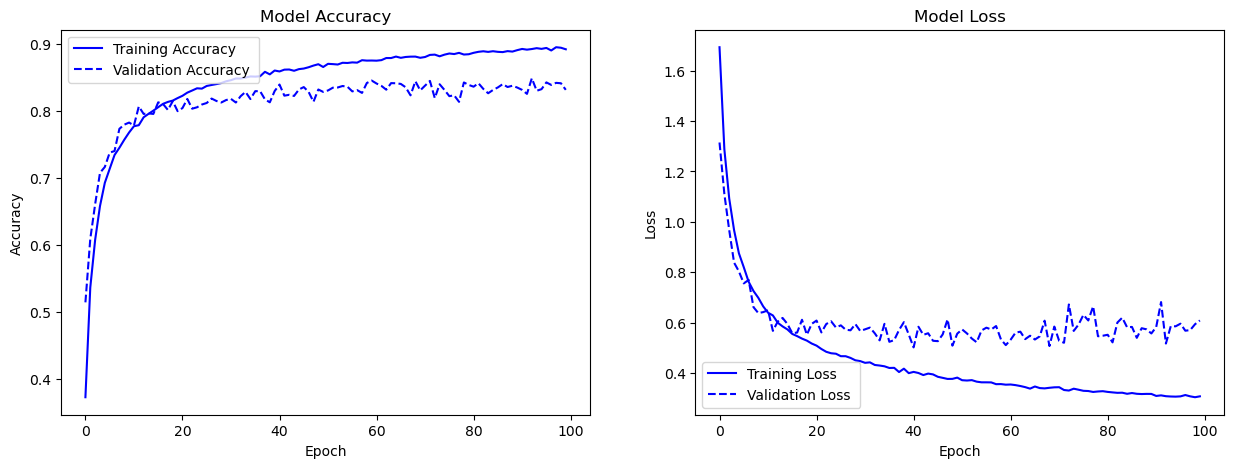

In [58]:
vgg_triple_block_data_augmentation_history = vgg_triple_block_data_augmentation.fit(
    data_generator.flow(x_train, y_train, batch_size=64), epochs=100,
    validation_data=(x_val, y_val))
plot_training_accuracy_loss([vgg_triple_block_data_augmentation_history])

Test accuracy: 0.8203999996185303
Test loss: 0.6578413844108582


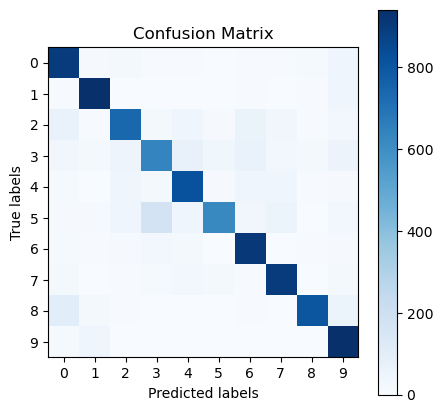

In [59]:
test_model(vgg_triple_block_data_augmentation)

Data augmentation showed to improve the performance of the model by the greatest amount of the regularisation tachniques explored. The level of overfitting has been reduced as the validation loss doesn't consistently increase as the training loss decreases. Also, the training accuracy is much closer to the validation accuracy.

Since all three types of regularisation have improved the performance of the model, it is worth exploring a model that uses all three types of regularisation.

In [60]:
vgg_triple_block_all_regularisation = Sequential([
    VGGBlockBatchNormalisation(filters=32, input_shape=(32, 32, 3)),
    Dropout(0.2),
    VGGBlockBatchNormalisation(filters=64),
    Dropout(0.3),
    VGGBlockBatchNormalisation(filters=128),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
vgg_triple_block_all_regularisation.compile(optimizer='adam',
                                            loss='categorical_crossentropy',
                                            metrics=['accuracy'])

Epoch 1/100
625/625 [==============================] - 13s 20ms/step - loss: 1.6033 - accuracy: 0.4156 - val_loss: 1.3889 - val_accuracy: 0.5110
Epoch 2/100
625/625 [==============================] - 13s 20ms/step - loss: 1.2396 - accuracy: 0.5528 - val_loss: 1.0719 - val_accuracy: 0.6228
Epoch 3/100
625/625 [==============================] - 12s 19ms/step - loss: 1.0626 - accuracy: 0.6214 - val_loss: 1.0305 - val_accuracy: 0.6420
Epoch 4/100
625/625 [==============================] - 12s 20ms/step - loss: 0.9651 - accuracy: 0.6532 - val_loss: 0.9151 - val_accuracy: 0.6848
Epoch 5/100
625/625 [==============================] - 12s 20ms/step - loss: 0.8940 - accuracy: 0.6871 - val_loss: 0.8194 - val_accuracy: 0.7171
Epoch 6/100
625/625 [==============================] - 12s 20ms/step - loss: 0.8472 - accuracy: 0.7021 - val_loss: 0.8706 - val_accuracy: 0.7120
Epoch 7/100
625/625 [==============================] - 12s 20ms/step - loss: 0.8039 - accuracy: 0.7200 - val_loss: 0.7985 - val_ac

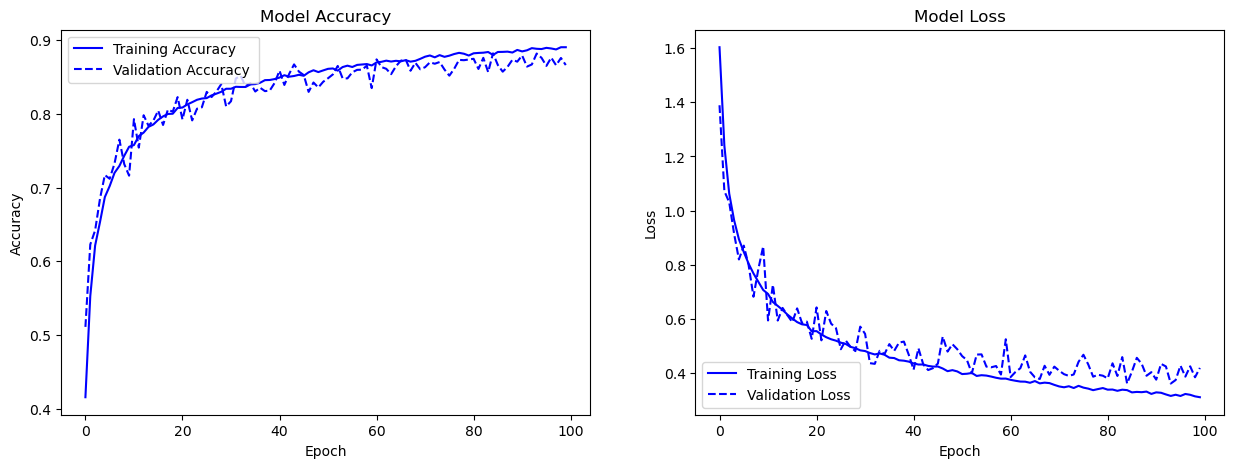

In [61]:
vgg_triple_block_all_regularisation_history = vgg_triple_block_all_regularisation.fit(
    data_generator.flow(x_train, y_train, batch_size=64), epochs=100,
    validation_data=(x_val, y_val))
plot_training_accuracy_loss([vgg_triple_block_all_regularisation_history])


Test accuracy: 0.8689000010490417
Test loss: 0.43390536308288574


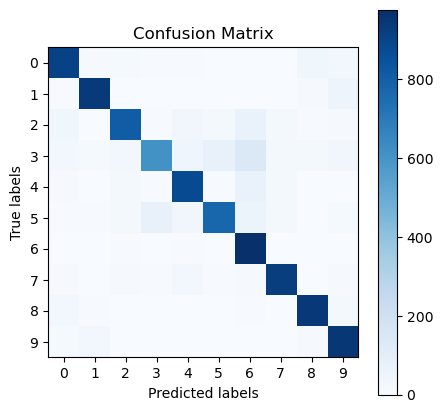

In [62]:
test_model(vgg_triple_block_all_regularisation)

As can be seen from the training and validation loss graph, this model is no longer overfitting the training data due to the combination of several regularisation techniques. The test accuracy is the highest seen of any model tested, as reflected in the confusion matrix, showing the potential of deep convolutional neural networks with regularisation for image classification.

## Conclusion <a class="anchor" id="conclusion"></a>

In [ ]:
def plot_accuracy_history(**kwargs):
    plt.figure(figsize=(8, 6))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, (name, history) in enumerate(kwargs.items()):
        color = colours[i % len(colours)]
        plt.plot(history.history['accuracy'], label=f"{name} train", color=color)
        plt.plot(history.history['val_accuracy'], label=f"{name} validation", color=color, linestyle='--')

    plt.title('VGG Block Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


def plot_loss_history(**kwargs):
    plt.figure(figsize=(8, 6))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, (name, history) in enumerate(kwargs.items()):
        color = colours[i % len(colours)]
        plt.plot(history.history['loss'], label=f"{name} train", color=color)
        plt.plot(history.history['val_loss'], label=f"{name} validation", color=color, linestyle='--')

    plt.title('VGG Block Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

### VGG Block Comparison <a class="anchor" id="vgg-block-comparison"></a>

First, create a graph to compare the performance of single, double and triple VGG blocks.

In [ ]:
plot_accuracy_history(single_vgg_block=vgg_single_block_model_history, double_vgg_block=vgg_double_block_model_history,
                      triple_vgg_block=vgg_triple_block_model_history)

As can be seen from the graph, the triple VGG block model has higher accuracy than the single and double block models. This may be because the triple VGG block model has more parameters so it's able to learn more complex features from the training data. As mentioned previously, the difference in validation accuracy between the single and double block models is larger than the difference between the double and triple block models which suggests that continuing to add more and more VGG blocks won't necessarily improve the performance of the model.

In [ ]:
plot_loss_history(single_vgg_block=vgg_single_block_model_history, double_vgg_block=vgg_double_block_model_history,
                  triple_vgg_block=vgg_triple_block_model_history)

### VGG Regularisation Comparison <a class="anchor" id="vgg-regularisation-comparison"></a>

In [ ]:
plot_accuracy_history(dropout=vgg_triple_block_model_dropout_history,
                      batch_normalisation=vgg_triple_block_batch_normalisation_history,
                      data_augmentation=vgg_triple_block_data_augmentation_history,
                      all_types=vgg_triple_block_all_regularisation_history)

In [ ]:
plot_loss_history(dropout=vgg_triple_block_model_dropout_history,
                  batch_normalisation=vgg_triple_block_batch_normalisation_history,
                  data_augmentation=vgg_triple_block_data_augmentation_history,
                  all_types=vgg_triple_block_all_regularisation_history)

In [ ]:
test_model(vgg_triple_block_model)
test_model(vgg_triple_block_all_regularisation)